In [9]:
import os
os.chdir('/Users/ros2/Documents/mpc_project')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy import sparse
import vehicle_dynamics.vehicle_models as vm 
import nonlinearmpcsolver as mpc
import utils
import os
import vehicle_dynamics.path_follower as pf

# Path Definition and Visualization

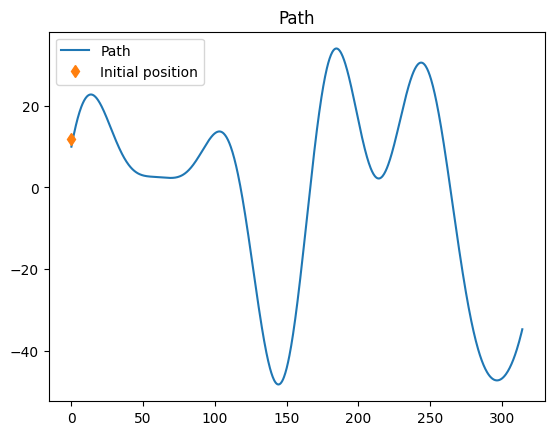

In [10]:
# Definition of sample path
x_ref = np.linspace(0, 100 * np.pi, 1000)
y_ref = np.sin(x_ref/40 * np.pi ) * 20 - np.sin(x_ref/70 * np.pi ) * 20 + np.cos(x_ref/30 * np.pi ) * 10 + np.sin(x_ref/80 * np.pi ) * 30
#x_ref = np.cos(np.linspace(0, 1, 1200))
#y_ref = np.sin(np.linspace(0, 1, 1200))


# Deffinition of the initial state
current_state = np.array([0., 12., np.pi/4, 8.0])


# Plot of the path
plt.plot(x_ref, y_ref, label='Path')
plt.plot(current_state[0], current_state[1], 'd', label='Initial position')
plt.title('Path')
plt.legend(loc='best')
plt.show()

# Initialize MPC Controller and Path Follower

In [11]:
os.chdir('/Users/ros2/Documents/mpc_project/vehicle_dynamics')


model_kin = vm.KinematicBicycleVariableSpeed('config_files/mpc_bicycle_velocity_config.yaml') 
n_horizon = 45
Q = sparse.diags([1, 1, 10, 20]) # State cost matrix
R = sparse.diags([0.5, 0.1]) # Input cost matrix

# Define the input constraints and State constraints (states unconstrained currently)
u_min_acc = -5.5
u_max_acc = 5.5
delta_min = -np.pi/5
delta_max = np.pi/5

InputConstraints = {'umin': [delta_min, u_min_acc], 
                    'umax': [delta_max, u_max_acc]}

StateConstraints = {'xmin': np.array([-np.inf, -np.inf, -np.inf, -np.inf]),
                    'xmax': np.array([np.inf, np.inf, np.inf, np.inf])}

# Define the MPC controller
mpc_controller = mpc.NMPCSolver(model=model_kin, N=n_horizon, Q=Q, R=R,
                             StateConstraints=StateConstraints,
                             InputConstraints=InputConstraints,
                             sqp_iters = 2,
                             alpha = 0.25,
                             debug_plotting_callback=utils.plot_xref_evolution,
                             debug_plots_folder='debug_plots/') 

# Define the path follower
path_follower = pf.PathFollower({'x': x_ref, 'y': y_ref}, mpc_controller, search_radius=None, sigma=400, maximum_velocity=10, maximum_lateral_acceleration=3)
path_follower.populate_trajectory() # Populate the trajectory with the reference path and the velocity profile - Refer to README for more details

# Simulation

In [12]:
# INITIALIZE SIMULATION

path_follower.search_radius = 500
state_history = [current_state]
input_history = []

n_sim = 0
debug = False


# Initialize lists to store velocities
vehicle_velocities = []
reference_velocities = []

from tqdm import tqdm
for i in tqdm(range(3000)):
    debug = False
    if n_sim % 50 == 0:
        debug = False
        
    optimal_input = path_follower.compute_optimal_input(current_state, debug=debug)
    current_state = model_kin.step_nonlinear_model(current_state, optimal_input[0])  
    input_history.append(optimal_input[0])
    state_history.append(current_state)
    vehicle_velocities.append(current_state[3])

    # Find the closest index on the reference trajectory
    closest_index = path_follower.find_closest_index(current_state, path_follower.trajectory,
                                                      start_index=path_follower.current_index,
                                                      search_radius=path_follower.search_radius)

    # Record the reference velocity at the closest index
    reference_velocities.append(path_follower.trajectory['v'][closest_index])
    
    # Plot fetched trajectory and input comparison
    if debug:
        path_follower.plot_fetched_trajectory_and_input(current_state, optimal_input, n_sim)
        input()
    
    n_sim += 1


# Prepare states for plotting
x_traj = [state_history[i][0] for i in range(n_sim)]
y_traj = [state_history[i][1] for i in range(n_sim)]
theta_traj = [state_history[i][2] for i in range(n_sim)]
v_traj = [state_history[i][3] for i in range(n_sim)]

# Prepare inputs for plotting
delta_input = [inp[0] for inp in input_history]
acc_input = [inp[1] for inp in input_history]

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:25<00:00, 115.52it/s]


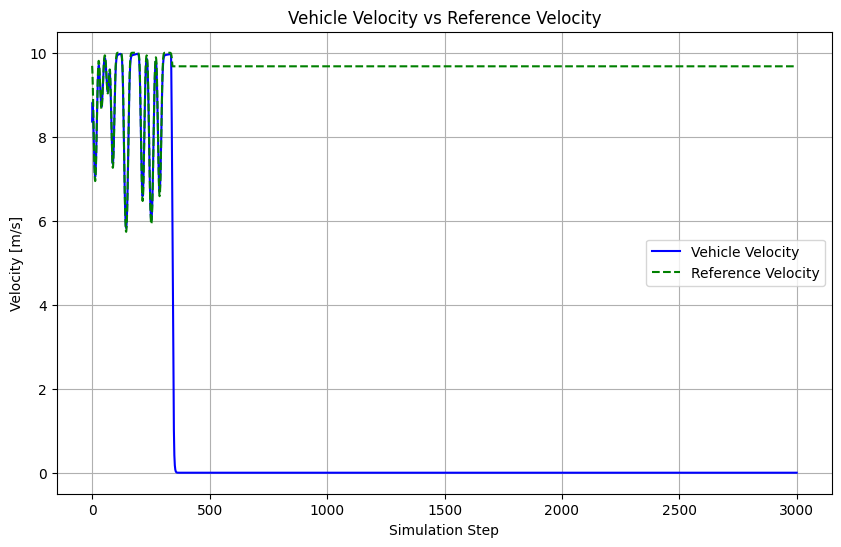

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(vehicle_velocities, label='Vehicle Velocity', color='blue')
plt.plot(reference_velocities, label='Reference Velocity', color='green', linestyle='--')
plt.title("Vehicle Velocity vs Reference Velocity")
plt.xlabel("Simulation Step")
plt.ylabel("Velocity [m/s]")
plt.legend()

plt.grid(True)
plt.savefig('simulations/velocity_comparison.pdf')
plt.show()



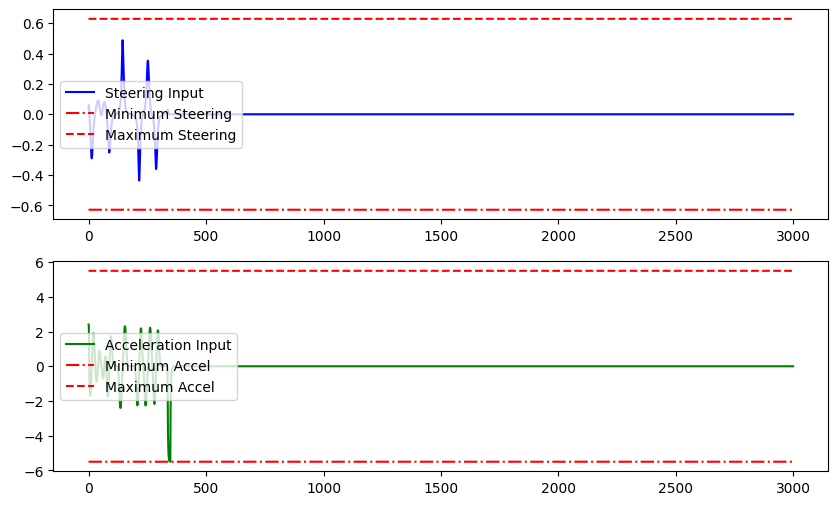

In [14]:

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(delta_input, label='Steering Input', color='blue')
plt.plot([delta_min]*len(input_history), label='Minimum Steering', color='red', linestyle='dashdot')
plt.plot([delta_max]*len(input_history), label='Maximum Steering', color='red', linestyle='--') 
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(acc_input, label='Acceleration Input', color='green')
plt.plot([u_min_acc]*len(input_history), label='Minimum Accel', color='red', linestyle='dashdot')
plt.plot([u_max_acc]*len(input_history), label='Maximum Accel', color='red', linestyle='--')
plt.savefig('simulations/input_comparison.pdf')
plt.legend(loc='best')
plt.show()




In [15]:
fig, ax = plt.subplots()
ax.plot(x_ref[:n_sim], y_ref[:n_sim], color='blue', label='reference')
line, = ax.plot([], [], color='orange', label='trajectory')

def init():
    line.set_data([], [])
    return line,

def update(frame):
    line.set_data(x_traj[:frame], y_traj[:frame])
    return line,

ani = animation.FuncAnimation(fig, update, frames=n_sim, init_func=init, blit=True)
ani.save('simulations/trajectory_animation.gif', writer='imagemagick')

MovieWriter imagemagick unavailable; using Pillow instead.
